# Imports

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Camera Calibration

## Build a function to undistort images

In [7]:
def undistort_images( images ):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Make a list of calibration images
    cal_images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in cal_images:

        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None);
    return list(map(lambda i: cv2.undistort(i, cameraMatrix, distCoeffs, None, cameraMatrix), images))

# Create thresholded binary images

In [10]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1 if orient=='x' else 0, 0 if orient=='x' else 1)
    # 3) Take the absolute value of the derivative or gradient
    sobelabs = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaledSobel = np.uint8(255*sobelabs / (np.max(sobelabs)))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaledSobel)
    binary_output[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    sobelMag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobelScaled = np.uint8( 255*sobelMag / np.max(sobelMag) )
    
    binary_output = np.zeros_like(sobelMag)
    # 5) Create a binary mask where mag thresholds are met
    binary_output[ (sobelScaled >= mag_thresh[0]) & (sobelScaled <= mag_thresh[1]) ]=1
    
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    sobelAngle = np.arctan2(sobely_abs, sobelx_abs)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobelAngle)
    binary_output[(sobelAngle >= thresh[0]) & (sobelAngle <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return binary_output

def hls_select(image, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hlsimg = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    s_channel = hlsimg[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output
    
def create_binary_threashold_images(images):
    final_images = []
    for img in images:
        img = np.copy(img)
                
        ksize = 3 
        gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(0, 255))
        grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
        mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 255))
        dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
        hls_binary = hls_select(img)

        combined = np.zeros_like(dir_binary)
        combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) & hls_binary == 1] = 1
        
        final_images.append(combined)
    return final_images
        

# Pipeline

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

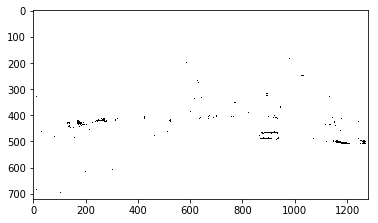

In [11]:
images = glob.glob('test_images/*.jpg')

new_images = list(map(cv2.imread, images))

undistorted_images = undistort_images( new_images )

threashold_images = create_binary_threashold_images( undistorted_images )

plt.imshow(threashold_images[5], cmap='gray')